In [2]:
import numpy as np
import scipy as sp
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  


In [3]:
rawdata = pd.read_excel('Industry_Portfolios.xlsx')
workdata = rawdata.drop(['Date'],axis =1)

C:\Users\kilohp\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [4]:
R = workdata.mean().to_numpy()
V = workdata.cov().to_numpy()
stdev = workdata.std()

In [5]:
resultdf = pd.concat([workdata.mean(),workdata.std()],axis=1).rename(columns = {0:'mean',1:'std dev'})
resultdf

,mean,std dev
NoDur,0.902833,3.345657
Durbl,0.733333,8.361852
Manuf,1.012833,5.310270
Enrgy,1.231167,6.081524
HiTec,0.766250,5.381191
Telcm,0.881417,4.448284
Shops,0.916333,4.093786
Hlth,0.783833,3.787172
Utils,0.907167,3.701763
Other,0.489083,5.582452


In [6]:
class mva():
    def __init__ (self,R,V):
        self.R = R #mean
        self.V = V #covariance matrix
        self.size =\
            len(self.R)
        self.V_inv =\
            np.linalg.inv(self.V)
        self.alpha =\
            np.dot(np.dot(self.R.T,self.V_inv),np.ones(self.size))
        self.zeta =\
            np.dot(np.dot(self.R.T,self.V_inv),self.R)
        self.delta =\
            np.dot(np.dot(np.ones(self.size),self.V_inv),np.ones(self.size))
        self.R_mv =\
            self.alpha/self.delta
        
    def var_mva(self,R_p):
        return \
            (1/self.delta) + (R_p- self.R_mv)**2 *(self.delta / (self.zeta * self.delta - self.alpha**2))
    
    def var_mva_with_riskfree(self,R_p,rf):
        return \
            ((R_p -rf)**2)/(self.zeta - 2*self.alpha*rf + self.delta * rf**2)
    
    def weights_calc(self,R_p):
        _multiplier_1 = ((self.delta * R_p - self.alpha)/(self.zeta * self.delta - self.alpha ** 2))
        _multiplier_2 = ((self.zeta - self.alpha * R_p )/(self.zeta * self.delta - self.alpha ** 2))
        return _multiplier_1 * (np.dot(self.V_inv,R)) +\
            _multiplier_2 * (np.dot(self.V_inv,np.ones(self.size)))
    
    def tangent_portfolio(self, R_p_list,rf):
        R_tg = (self.alpha * rf - self.zeta)/(self.delta * rf - self.alpha)
        var_tg = (self.zeta - 2 * self.alpha *rf + self.delta * rf**2) / (self.delta ** 2 * (rf- self.R_mv) ** 2)
        sharpe_ratio = (R_tg -rf) / np.sqrt(var_tg)
        tangent_weights = self.weights_calc(R_tg)
        return {'return': R_tg,
                'var':var_tg,
                'std_dev': np.sqrt(var_tg),
                'sharpe_ratio': sharpe_ratio,
                'tangent_weights' : tangent_weights}
        

In [7]:
newmva = mva(R,V)

## 1. Briefly explain the economic significance and relevance of the minimum-variance frontier  to an investor. ##

* The minimum-variance frontier plots what is the minimum amount of risk for a given expected portfolio return. 
* A risk-averse investor can use this curve to choose what portfolio to invest in based on the investor's risk appetite (standard deviation of return). 
* The affine combination of frontier portfolios will also result in a frontier portfolio
* The global minimum variance portfolio is the point where the standard deviation is the lowest. At this point, the portfolio has the lowest amount of minimized risk (red x point)


201


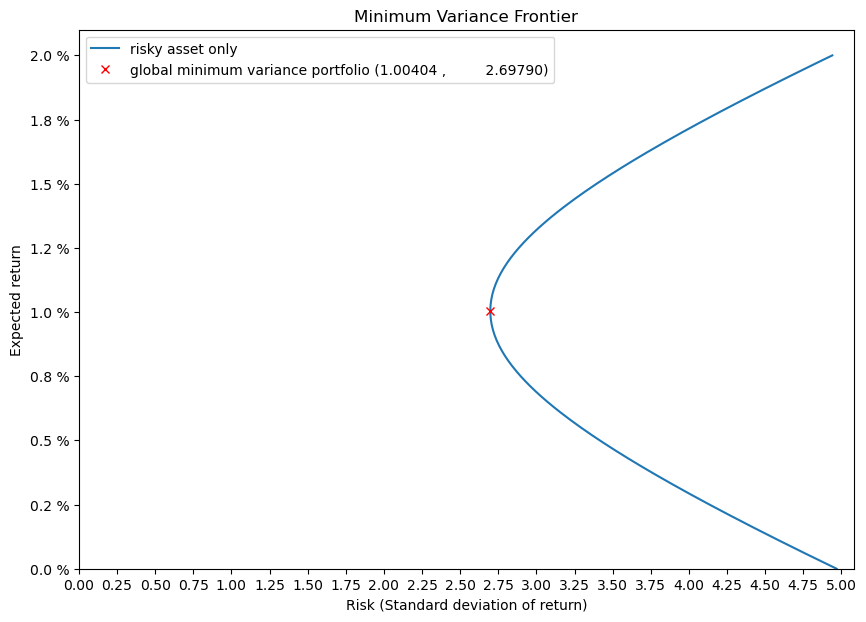

In [8]:
possible_rp  = np.arange(0,2.01,0.01)
print(len(possible_rp))
var_list = []
for x in possible_rp :
    var_list.append(newmva.var_mva(x))
f1, ax1 = plt.subplots(1)
f1.set_figheight(7)
f1.set_figwidth(10)
ax1.plot(np.sqrt(var_list), possible_rp,label = "risky asset only")
ax1.plot(np.sqrt(newmva.var_mva(newmva.R_mv)),newmva.R_mv,'rx',\
         label = f"global minimum variance portfolio ({newmva.R_mv:.5f} ,\
         {np.sqrt(newmva.var_mva(newmva.R_mv)):.5f})")
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin=0)
ax1.set_xlabel("Risk (Standard deviation of return)")
ax1.set_ylabel("Expected return")
ax1.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax1.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax1.set_title("Minimum Variance Frontier")
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax1.legend()
plt.show(f1)
f1.savefig('assignment1_f1.jpg')

## 2. Briefly explain the economic significance and relevance of the efficient frontier to an investor. ##
* The upper half of the minimum-variance frontier curve relative to the global minimum variance portfolio point is known as the efficient frontier. 
* A risk-averse investor should choose to invest in portfolios that lie on the efficient frontier because it gives the highest expected return for a specific risk compared to choosing the portfolio that lies on the lower half of the minimum-variance frontier curve 

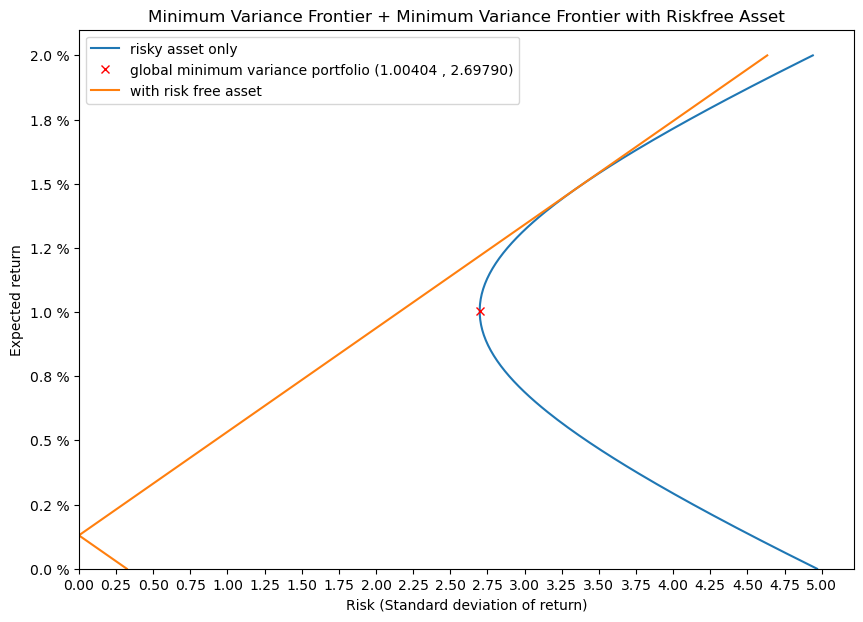

In [9]:
rf = 0.13
var_list_riskfree = []
for x in possible_rp :
    var_list_riskfree.append(newmva.var_mva_with_riskfree(x,rf))
f2, ax2 = plt.subplots(1)
f2.set_figheight(7)
f2.set_figwidth(10)
ax2.plot(np.sqrt(var_list), possible_rp,label = "risky asset only")
ax2.plot(np.sqrt(newmva.var_mva(newmva.R_mv)),newmva.R_mv,'rx',\
         label = f"global minimum variance portfolio ({newmva.R_mv:.5f} , {np.sqrt(newmva.var_mva(newmva.R_mv)):.5f})")
ax2.plot(np.abs(np.sqrt(var_list_riskfree)), possible_rp, label = "with risk free asset")
ax2.set_ylim(ymin=0)
ax2.set_xlim(xmin=0)
ax2.set_xlabel("Risk (Standard deviation of return)")
ax2.set_ylabel("Expected return")
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax2.set_title("Minimum Variance Frontier + Minimum Variance Frontier with Riskfree Asset")
ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax2.legend()
plt.show(f2)
f2.savefig('f2.jpg')

## 3. Briefly explain the economic significance and relevance of the tangency portfolio to an investor. ##
* When the a riskfree asset is included to the portfolio, the efficient frontier becomes a straight line which is tangent to the hyperbola curve at ($R_{tg}, \sigma_{tg}$). Another name for this line is the **Capital Market Portfolio**
* This efficient frontier line also intersects the Y axis at $R_f$ when a riskfree asset is included. This is to signify the inclusion of a riskfree asset (e.g. bonds, deposits) with return $R_f$ and 0 standard deviation (hence risk free)
* If the risk free rate is lower than global minimum variance return ($R_f < R_{mv}$), then the tangency portfolio is the point that offers the highest risk to reward ratio as the slope of the line (also known as the **sharpe ratio**) is the highest.
* For risk-averse investors who chose to incorporate a risk free asset into their portfolio, choosing to invest in the tangent portfolio means putting 100% of their wealth in risky assets.
* For this scenario, if an investor chooses to invest in portfolios

In [10]:
tangent_portfolio = newmva.tangent_portfolio(possible_rp,0.13)


In [11]:
noweights = newmva.tangent_portfolio(possible_rp,0.13)
noweights.pop('tangent_weights')
pd.DataFrame.from_dict(noweights, orient ='index')

,0
return,1.486274
var,11.294481
std_dev,3.360726
sharpe_ratio,0.403566


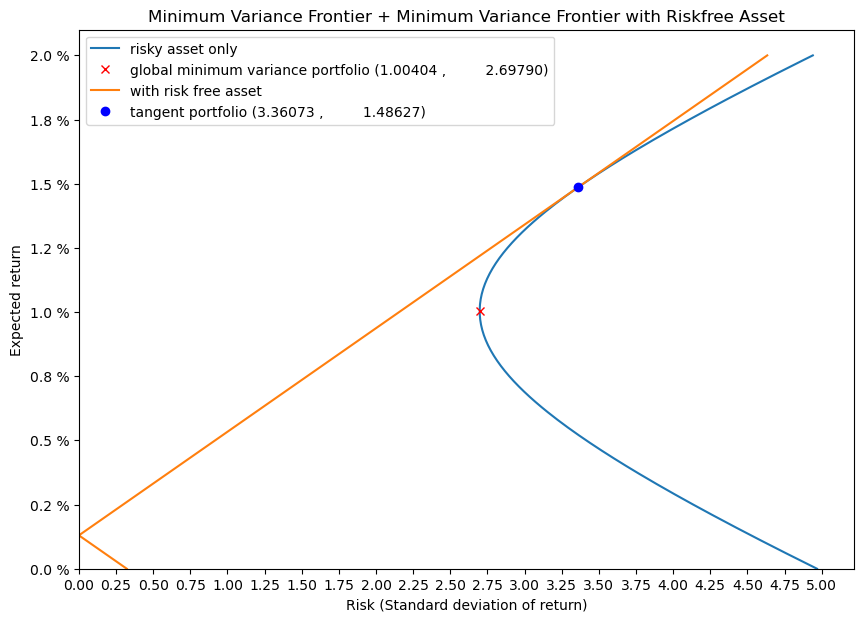

In [12]:
rf = 0.13
var_list_riskfree = []
for x in possible_rp :
    var_list_riskfree.append(newmva.var_mva_with_riskfree(x,rf))
    
f3, ax3 = plt.subplots(1)
f3.set_figheight(7)
f3.set_figwidth(10)
ax3.plot(np.sqrt(var_list), possible_rp,label = "risky asset only")
ax3.plot(np.sqrt(newmva.var_mva(newmva.R_mv)),newmva.R_mv,'rx',\
         label = f"global minimum variance portfolio ({newmva.R_mv:.5f} ,\
         {np.sqrt(newmva.var_mva(newmva.R_mv)):.5f})")
ax3.plot(np.sqrt(var_list_riskfree), possible_rp, label = "with risk free asset")
ax3.plot(tangent_portfolio['std_dev'],tangent_portfolio['return'],'bo', \
         label = f"tangent portfolio ({tangent_portfolio['std_dev']:.5f} ,\
         {tangent_portfolio['return']:.5f})")
ax3.set_ylim(ymin=0)
ax3.set_xlim(xmin=0)
ax3.set_xlabel("Risk (Standard deviation of return)")
ax3.set_ylabel("Expected return")
ax3.xaxis.set_major_locator(plt.MultipleLocator(0.25))
ax3.set_title("Minimum Variance Frontier + Minimum Variance Frontier with Riskfree Asset")
ax3.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f %%"))
ax3.legend()
plt.show(f3)
f3.savefig('f3.jpg')

In [13]:
tangent_portfolio_weights_df = pd.concat( [pd.Series(resultdf.index), pd.Series(tangent_portfolio['tangent_weights'])],axis = 1)\
    .rename(columns = {0:'Industries',1:'Weight'})

In [14]:
tangent_portfolio_weights_df

,Industries,Weight
0,NoDur,0.567972
1,Durbl,-0.214073
2,Manuf,0.714105
3,Enrgy,0.104087
4,HiTec,-0.363438
5,Telcm,-0.095463
6,Shops,0.991647
7,Hlth,0.075570
8,Utils,0.132643
9,Other,-0.913051


In [15]:
vars(newmva)

{'R': array([0.90283333, 0.73333333, 1.01283333, 1.23116667, 0.76625   ,
        0.88141667, 0.91633333, 0.78383333, 0.90716667, 0.48908333]),
 'V': array([[11.19342216, 18.44966611, 14.10490703, 10.5313412 , 12.92294937,
         11.96807831, 10.17083232,  9.95311174,  7.86665347, 14.4384085 ],
        [18.44966611, 69.92057703, 39.1780972 , 27.0197944 , 35.4666521 ,
         27.49054314, 27.44473081, 16.82400308, 12.74613641, 39.36198711],
        [14.10490703, 39.1780972 , 28.19897006, 23.14537986, 24.61873929,
         19.55014973, 17.62286678, 13.59644703, 11.4406123 , 26.31342279],
        [10.5313412 , 27.0197944 , 23.14537986, 36.98493308, 19.26727584,
         15.36681682, 11.29780011,  9.63032658, 14.02716804, 18.32046915],
        [12.92294937, 35.4666521 , 24.61873929, 19.26727584, 28.95722027,
         18.70827342, 17.83711471, 13.25406408, 10.30418676, 23.85547048],
        [11.96807831, 27.49054314, 19.55014973, 15.36681682, 18.70827342,
         19.78722739, 14.16935566